# Introduction

### Problem Statement

Sepsis is a life-threatening medical condition that is caused by the spread of infection in one’s body, resulting in multiple organ failure or even death in many cases. Since it is a serious issue which can cause death, prediction of survival in such cases is among the top priorities of medical community today. Though we have a lot of sophisticated medical laboratories that can provide useful information about the patient, yet these things take their time, and might not be available immediately, not allowing medical practitioners to detect an urgent life threat and treat accordingly.

### Problem Solution: Machine Learning

Machine learning can be applied in this setting to get faster results. It can help build a model which can take in variables that can be easily retrieved, and if dataset available is large enough and contains balanced information on alive and deceased patients, can give accurate predictions of survival based on a handful of related inputs only.

This project is inspired from a research that aims to show that prediction of survival from Sepsis can be done with minimal predictor variables that are very easily available, allowing medical practitioners to quickly indentify patient outcomes. Original researchers have used a total of 5 different machine learning alogrithms and showed the accuracy of models trained by using only 3 predictor variables. I have used 4 machine learning alogorithms I think can be useful in this situation to validate the claim made by the researchers in their paper.
Please refer to the research paper attached for any reference during this project. The official link to the paper is https://www.nature.com/articles/s41598-020-73558-3.

Purpose of this project is to predict the survival of patients with sepsis from age, sex and septic episode number as predictor variables. Different classifier methods will used and the one with better performance metrics will be recommended for Sepsis prediction on real dataset after being trained on data available.

### Description of datasets used

I have used two datasets for this part of the project:

1. 's41598-020-73558-3_sepsis_survival_study_cohort.csv'

2. 's41598-020-73558-3_sepsis_survival_validation_cohort.csv'

Dataset 1 is made of 19,051 admissions of hospitalized subjects between 2011 and 2012 in Norway who were diagnosed with infections, systemic inflammatory response syndrome (SIRS), sepsis by causative microbes, or septic shock. The data comes from the Norwegian Patient Registry and the Statistics Norway agency (please refer research paper for further details)

Dataset 2 consists of South Korean critically ill patients whose medical records were collected between between January 2007 and December 2015 and publically released by Lee and colleagues. From their original dataset, researchers selected the data of 137 patients who had already 1 or 2 septic episodes and tested their model on this dataset to further corroborate their findings.

So in this project I will be training the machine learning model on Dataset 1 (that is the study cohort) and then test the resulting model on the instances of Dataset 2.

The datasets can be found in the GitHub repository for this code

# Data Exploration

Importing the required libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Reading in the data file

In [2]:
patients=pd.read_csv('s41598-020-73558-3_sepsis_survival_study_cohort.csv')

### Exploring the structure of dataset

In [3]:
patients.head() # checking some top rows in the dataset

,age_years,sex_0male_1female,episode_number,hospital_outcome_1alive_0dead
0,7,1,1,1
1,17,0,2,1
2,70,0,1,1
3,76,0,1,1
4,8,0,1,1


In [4]:
patients.info() # this tells about the number of instances in every column, their data types and presence of null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19051 entries, 0 to 19050
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   age_years                      19051 non-null  int64
 1   sex_0male_1female              19051 non-null  int64
 2   episode_number                 19051 non-null  int64
 3   hospital_outcome_1alive_0dead  19051 non-null  int64
dtypes: int64(4)
memory usage: 595.5 KB


So there are no null values in the dataset. All variables, including predictors and outcome class is of integer data type, which implies that we have discreet data points for every instance

In [5]:
patients.describe() # this tells about some standard statistical measures like mean, min, max, quartiles for values in every column

,age_years,sex_0male_1female,episode_number,hospital_outcome_1alive_0dead
count,19051.000000,19051.000000,19051.000000,19051.000000
mean,72.503228,0.448585,1.396252,0.810719
std,18.614470,0.497363,0.783749,0.391742
min,0.000000,0.000000,1.000000,0.000000
25%,65.000000,0.000000,1.000000,1.000000
50%,77.000000,0.000000,1.000000,1.000000
75%,85.000000,1.000000,2.000000,1.000000
max,100.000000,1.000000,5.000000,1.000000


The proportion of male population is more, as the average of 0 and 1 is less than 0.5, implying presence of more 0, that is males in the dataset. Mostly patients have had upto 2 episodes of Sepsis before, at the time of collection of this dataset, though the maximum number of episodes go upto 5. The number of alive people in dataset is way more than those deceased.
Based on above age ranges, patients appear to be in their fifties and sixties onwards. But the minimum for age_years value is 0, which means there are patient records in the dataset where age is put as 0, which is not possible. Let's explore this further

In [6]:
sum(patients['age_years']==0) # number of patients having zero age. Code inside the sum() gives a series of boolean values. When summned, the true values add up as 1, giving the number of cases where the comparison of age_years=0 is True

63

Checking numbers of rows in dataset where age column contains 0 value. It turns out that 63 rows contain age as 0. Seeing the distribution of age in data visualization performed (in the following blocks of code), the age goes from 0 to 100 and it is an integer value as seen in the info(). So age 0 might be the cases where patients were new born babies and were not even 1 year old when they were admitted to the hospital. Since the age cannot be floating type, the person who recorded the data could have put the age as 0 for babies who were less than 1 year old. Since this seems to present a somewhat practical approach, when data is constrained by data type (integer only), we can move forward with age as 0. But one has to make sure that the model trained on such data should only be applied to test data with the same data types for all variables as our dataset, and the same methodology of assigning 0 to new borns has been followed while collecting the test data also

In [7]:
patients.drop(['hospital_outcome_1alive_0dead'],axis=1).corr() # checking for correlation between the predictor variables used

,age_years,sex_0male_1female,episode_number
age_years,1.000000,0.063937,-0.068292
sex_0male_1female,0.063937,1.000000,-0.039642
episode_number,-0.068292,-0.039642,1.000000


As it can be seen, there is no correlation between the 3 predictor variables chosen for this analysis

### Data Visualization

Checking the class imbalance of data, i.e. number of patient records who survived vs patients who did not survive.
It can be seen that there is a considerable imbalance in the data.

<AxesSubplot:xlabel='hospital_outcome_1alive_0dead', ylabel='Count'>

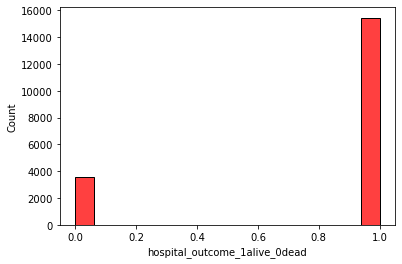

In [8]:
sns.histplot(patients['hospital_outcome_1alive_0dead'],color='red')

Checking the distribution of all three predictor variables with respect to the hospital outcome of survivial or death

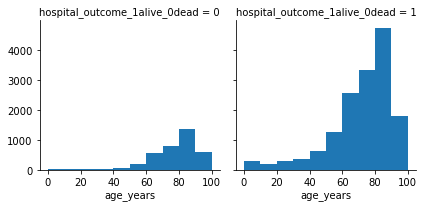

In [9]:
g=sns.FacetGrid(data=patients,col='hospital_outcome_1alive_0dead') # this makes an underlying plot which divides the upcoming plot space based on values specified in col
g.map(plt.hist,'age_years') # g.map allows the plot created to be divided into the segments created by FacetGrid in above line of code

It appears from the distribution that the majority of deceased people are above 50 years of age. The majority of people who survived also appear to be coming from the same age group. But there are some instances of younger population also. One may conclude that people below the age of 40 rarely die of Sepsis based on this data. But a possible case could also be that young patients who deceased did not come to those hospitals from where this data was collected. Since the dataset available is very imbalanced, there could have been cases of deceased young patients but were not recorded in this dataset, as this dataset has about 80% cases of only those patients who survived

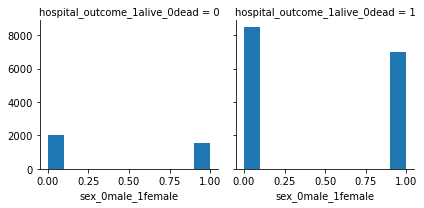

In [10]:
g=sns.FacetGrid(data=patients,col='hospital_outcome_1alive_0dead')
g.map(plt.hist,'sex_0male_1female') # same is done for sex column

There does not appear to be a substantial relationship between male and female proportion in both survived and deceased cases. But the count of males is more in both cases. This can be due to the presence of more males in the dataset collected than the number of females 

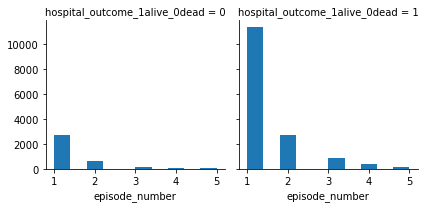

In [11]:
g=sns.FacetGrid(data=patients,col='hospital_outcome_1alive_0dead')
g.map(plt.hist,'episode_number') # same is done for episode_number column

Majority of patients in both cases have upto 2 number of sepsis episode. Assuming that the data represents an unbiased picture of sepsis cases, one can infer that chances of survival decrease very much once a person has had 2 episodes of Sepsis before. That is why in the dataset, patients reporting to the hospital with more than 2 episodes of Sepsis before are very less in both categories of patients as compared to the ones with upto 2 episodes of Sepsis

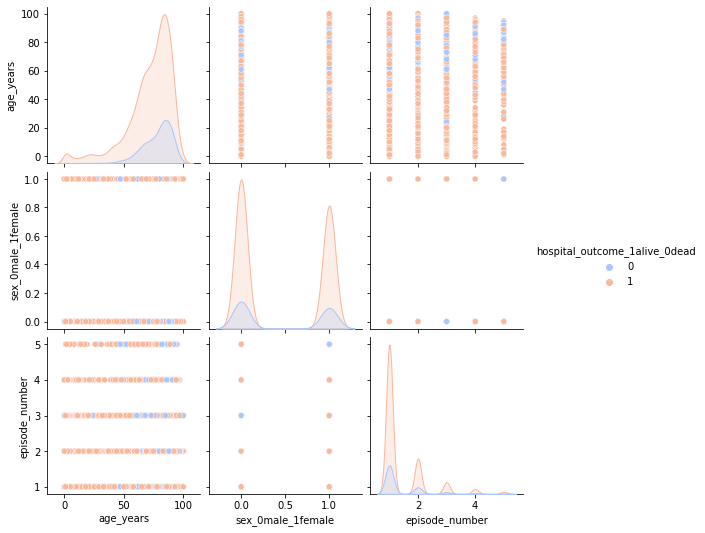

In [12]:
sns.pairplot(data=patients,hue='hospital_outcome_1alive_0dead',palette='coolwarm') 

Based upon the overall visualizations, one can state that it is very difficult to infer something concrete about the relationship of these 3 predictor variables with the outcome. It is mainly because of the heavy imbalance in the dataset, which contains more than 80% of the instances belonging to people who survived and according to those we have the majority of values for predictors also

# Data Models Using Machine Learning

### Model 1: Logisitic Regression (starting with the most basic models in ML for binary classification)

Importing the required packages for LogisitcRegression and evaluation metrics used

In [13]:
from sklearn.linear_model import LogisticRegression  # for data modelling using Logistic Regression
from sklearn.model_selection import cross_val_score,StratifiedKFold
# StratifiedKFold ensures that class distribution is maintained during the random data splits. This is especially useful in case of imbalanced datasets
# In every split of test and train data, observations in both contain all the available class labels as per the proportion of class labels in original dataset, which is divided into test and train 

In [14]:
X=patients[['age_years','sex_0male_1female','episode_number']].values # getting the values of predictor variables
y=patients['hospital_outcome_1alive_0dead'].values # getting the values of outcome variable
cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=1) # defining the cross validation method as 5-fold Cross Validation

Now if we proceed with directly dividing our data into train and test, apply a model and check it's accuracy, then there are high chances that we will end up with a model which will predict Survival i.e. class label of 1 for all the instances in test dataset. This is infact going to be devastating, as it is going to predict survival for those who are actually going to die, thus devoiding them of the urgent care which they need (If doctors at any hospital use a model based on above stated methodology)

Suppose we follow a 80-20 split rule for our model. Training the model on 80% of the data and testing on 20%. The machine learning algorithm will learn based on that 80% data. Now, if we consider any machine learning algorithm, the main underlying mathematical cost function always aims to be as accurate as possible on the training data that it is given. Regression reduces Sqaures of Errors, Decision Trees reduce entropy and so on. Moreover, any model is as good as the data which we use to train it. Now in this case, the data is heavily imbalanced with the cases of survived patients. Thus any machine learning algorithm will have a hard time learning the actual values of predictors that really effect the outcome, and chances are that it will predict the majority class for any value of predictor variables given to it, because it has been trained mainly for doing good on patients who survived

This is the problem which is faced when one wants to use a classifier on datasets with imbalanced classes.
An obvious solution to the above problem, is to gather more data which belongs to the minority class.
But it is not always possible, like in our case, where maybe, the number of people dying in real is 1 out of 5, thus placing a natural limit on the data points available to us for minority class

To counter this problem and make a better model, I have used 3 methods which try to generate synthetic data points for minority class label instances, based on the available data points belonging to minority class in the original dataset. Thus these methods are also called OverSampling techniques.
For all three techniques, I have used 5Fold Cross Validation to get the ROC Area Under Curve as a performance metric to select the best oversampling technique for a particular classifier used on the patients dataset. ROC AUC has been used because we are not only concerned with the model's performance of predicting class label 1 (survival) but also concerned with the prediction of 0 (death). If one only needs to check prediction accuracy of class label 1 (survival in this case) then Precison Recall Area Under Curve can also be used.For more information on ROC AUC, you can check the following sklearn official documentation:

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html?highlight=roc_auc#sklearn.metrics.roc_auc_score

Below is a brief description of the three Oversampling techniques used

Random Over Sampling: It involves randomly duplicating examples from the minority class and
adding them to the training dataset. Examples from the training dataset are selected randomly with replacement

SMOTE (Synthetic Minority OverSampling Technique): It first selects a minority class instance A at random and finds its k nearest minority class neighbors (typically k=5). The synthetic instance is then created by choosing one of the k nearest neighbors B at random and connecting A and B to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances A and B

BorderlineSMOTE: It involves selecting those instances of the minority class that are misclassified, such as with a k-nearest neighbor classification model. We can then oversample just those difficult instances, providing more resolution only where it may be required. Identifying instances of minority class that are misclassified can also be done by SVM instead of KNN, in case of BorederlineSMOTE in order to arrive at new synthetic data points for minority class

In [15]:
# importing the required functions
from imblearn.over_sampling import RandomOverSampler  # random over sampling
from imblearn.over_sampling import SMOTE # Synthetic Minority Oversampling
from imblearn.over_sampling import BorderlineSMOTE # Borderline SMOTE
from imblearn.pipeline import Pipeline # this is defined for Cross Validation

The purpose of Pipeline is to ensure that during KFold CV, for every fold we have, the oversampling is done only on the training data, the testing data is kept intact as per the original dataset. 
The main motive of OverSampling is to prepare a better model, which can make better predictions.
So the oversampling should be only applied to the data used to train a model, testing needs to be done on the original data only. In real life also, we will not be testing our model on synthetic data, it will be tested on real data. So Pipeline ensures that the training data only in each Fold is oversampled, the test data remains intact and then the model is applied

In [16]:
steps1=[('over',RandomOverSampler(sampling_strategy='minority',random_state=1)),('model',LogisticRegression())] # defining Pipeline for LogisticRegression Model
# sampling strategy = 'minority' makes the minority class to be oversampled till it's number become equal to majority class
# random_state is set to 1 for reproducability of this code, just like setting a random seed
pipeline1=Pipeline(steps=steps1) # steps contain RandomOverSampler as we are doing Random Over Sampling
score1=np.mean(cross_val_score(pipeline1,X,y,scoring='roc_auc',cv=cv,n_jobs=-1)) # taking mean of roc_auc obtained in each fold to get overall score
print(score1)

0.5896025099172861


In [17]:
# same process is followed with SMOTE
steps2 = [('over', SMOTE()), ('model', LogisticRegression())]
pipeline2 = Pipeline(steps=steps2)
score2 = np.mean(cross_val_score(pipeline2, X, y, scoring='roc_auc', cv=cv, n_jobs=-1))
print(score2)

0.5901676243128071


In [18]:
# same process with Borderline SMOTE
steps3 = [('over', BorderlineSMOTE()), ('model', LogisticRegression())]
pipeline3=Pipeline(steps=steps3)
score3 = np.mean(cross_val_score(pipeline3, X, y, scoring='roc_auc', cv=cv, n_jobs=-1))
print(score3)

0.5907866690168755


So using all three OverSampling Techniques, there is a minimal difference in the ROC AUC reported by all three. But still, to consider the best, we compare all the quantities and get Borderline SMOTE as the best option in case of Logistic Regression Model.These results may vary slightly when run on different machines or run repeatedly, based on the stochastic nature of dataset and sampling strategy. In my case I am using the best one as per the current results

### Model 2: Random Forest Classifier

In [19]:
from sklearn.ensemble import RandomForestClassifier # importing RandomForestClassifier model

In [20]:
# same process is repeated again for Random Forest Classifier
steps4 = [('over', RandomOverSampler(sampling_strategy='minority')), ('model', RandomForestClassifier())] # now model is changed to RandomForestClassifier
pipeline4 = Pipeline(steps=steps4) # Random Over Sampling
score4 = np.mean(cross_val_score(pipeline4, X, y, scoring='roc_auc', cv=cv, n_jobs=-1))
print(score4)

0.5598171975423691


In [21]:
steps5 = [('over', SMOTE()), ('model', RandomForestClassifier())]
pipeline5 = Pipeline(steps=steps5) # SMOTE Over Sampling
score5 = np.mean(cross_val_score(pipeline5, X, y, scoring='roc_auc', cv=cv, n_jobs=-1))
print(score5)

0.5612680260004723


In [22]:
steps6 = [('over', BorderlineSMOTE()), ('model', RandomForestClassifier())]
pipeline6 = Pipeline(steps=steps6) # Borderline SMOTE
score6 = np.mean(cross_val_score(pipeline6, X, y, scoring='roc_auc', cv=cv, n_jobs=-1))
print(score6)

0.554095632895617


So using all three OverSampling Techniques, there is a minimal difference in the ROC AUC reported by all three. But still, to consider the best, we compare all the quantities and get Random Over Sampling as the best option in case of Random Forest Classifier. These results may vary slightly, based on the stochastic nature of dataset and sampling strategy. In my case I am using the best one as per the current results

### Model 3: Naive Bayes

In [23]:
from sklearn.naive_bayes import MultinomialNB # Naive Bayes Classifier

In [24]:
steps7 = [('over', RandomOverSampler()), ('model', MultinomialNB())]
pipeline7 = Pipeline(steps=steps7) # Random OverSampling
score7 = np.mean(cross_val_score(pipeline7, X, y, scoring='roc_auc', cv=cv, n_jobs=-1))
print(score7)

0.5627894242779863


In [25]:
steps8 = [('over', SMOTE()), ('model', MultinomialNB())]
pipeline8 = Pipeline(steps=steps8) # SMOTE
score8 = np.mean(cross_val_score(pipeline8, X, y, scoring='roc_auc', cv=cv, n_jobs=-1))
print(score8)

0.5624034763812907


In [26]:
steps9 = [('over', BorderlineSMOTE()), ('model', MultinomialNB())]
pipeline9 = Pipeline(steps=steps9) # Borderline SMOTE
score9 = np.mean(cross_val_score(pipeline9, X, y, scoring='roc_auc', cv=cv, n_jobs=-1))
print(score9)

0.5611014654706008


Random Over Sampling is best here for Naive Bayes.These results may vary slightly, based on the stochastic nature of dataset and sampling strategy. In my case I am using the best one as per the current results

### Model 4: Support Vector Classifier

In [27]:
from sklearn.svm import SVC # Support Vector Classifier

In [28]:
steps10 = [('over', RandomOverSampler()), ('model', SVC())]
pipeline10 = Pipeline(steps=steps10) # Random Over Sampling
score10 = np.mean(cross_val_score(pipeline10, X, y, scoring='roc_auc', cv=cv, n_jobs=-1))
print(score10)

0.5871474806415766


In [29]:
steps11 = [('over', SMOTE()), ('model', SVC())]
pipeline11 = Pipeline(steps=steps11) # SMOTE
score11 = np.mean(cross_val_score(pipeline11, X, y, scoring='roc_auc', cv=cv, n_jobs=-1))
print(score11)

0.5882684863901647


In [30]:
steps12 = [('over', BorderlineSMOTE()), ('model', SVC())]
pipeline12 = Pipeline(steps=steps12) # Borderline SMOTE
score12 = np.mean(cross_val_score(pipeline12, X, y, scoring='roc_auc', cv=cv, n_jobs=-1))
print(score12)

0.5880764608154543


SMOTE turns out to be best for SVC.These results may vary slightly, based on the stochastic nature of dataset and sampling strategy. In my case I am using the best one as per the current results

### Training Model on Study Cohort and Testing on Validation Cohor

In [31]:
new_records=pd.read_csv('s41598-020-73558-3_sepsis_survival_validation_cohort.csv') # importing the validation dataset as new_records

In [32]:
new_records.head()

,age_years,sex_0male_1female,episode_number,hospital_outcome_1alive_0dead
0,20,0,1,1
1,22,0,1,1
2,26,1,2,0
3,33,1,1,1
4,33,0,1,1


In [33]:
new_records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   age_years                      137 non-null    int64
 1   sex_0male_1female              137 non-null    int64
 2   episode_number                 137 non-null    int64
 3   hospital_outcome_1alive_0dead  137 non-null    int64
dtypes: int64(4)
memory usage: 4.4 KB


In [34]:
new_records.describe()

,age_years,sex_0male_1female,episode_number,hospital_outcome_1alive_0dead
count,137.000000,137.000000,137.000000,137.000000
mean,59.540146,0.343066,1.160584,0.824818
std,15.748956,0.476475,0.368494,0.381518
min,20.000000,0.000000,1.000000,0.000000
25%,50.000000,0.000000,1.000000,1.000000
50%,60.000000,0.000000,1.000000,1.000000
75%,72.000000,1.000000,1.000000,1.000000
max,89.000000,1.000000,2.000000,1.000000


<AxesSubplot:xlabel='hospital_outcome_1alive_0dead', ylabel='Count'>

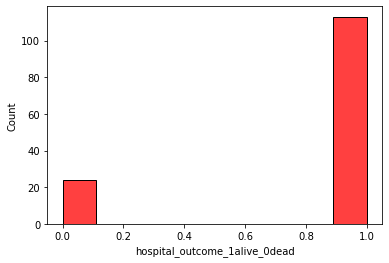

In [35]:
sns.histplot(new_records['hospital_outcome_1alive_0dead'],color='red')

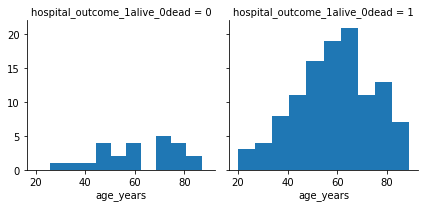

In [36]:
g=sns.FacetGrid(data=new_records,col='hospital_outcome_1alive_0dead')
g.map(plt.hist,'age_years')

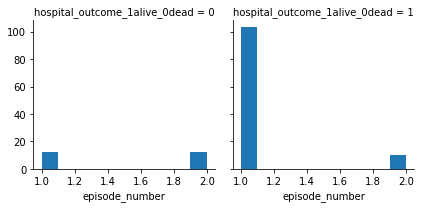

In [37]:
g=sns.FacetGrid(data=new_records,col='hospital_outcome_1alive_0dead')
g.map(plt.hist,'episode_number')

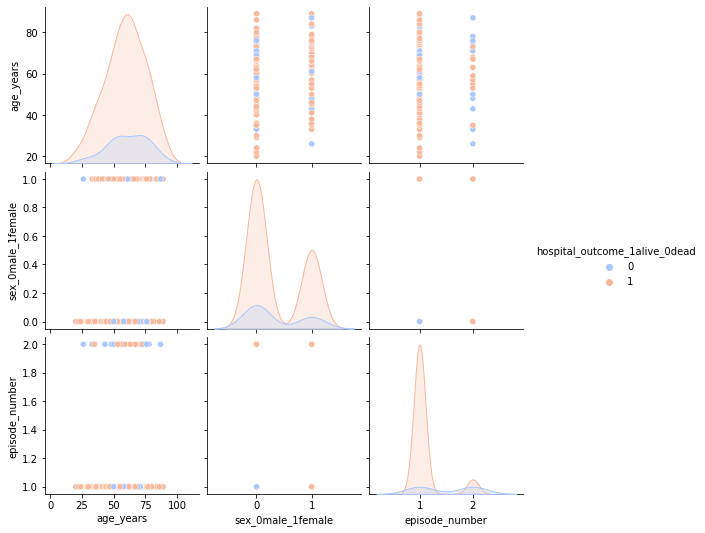

In [38]:
sns.pairplot(data=new_records,hue='hospital_outcome_1alive_0dead',palette='coolwarm')

The data is similary imbalanced, with number of survived patients way more than those deceased

Below, I have used all the four machine learning algorithms defined above for getting predictions on new data. 
First, I train the model directly using the original dataset (patients) and then use the model to predict values for data points in new_records.

Then I use the patients dataset, oversample it with the best technique identified above and then use it for predicting values for the data points in new_records

In [39]:
from sklearn.metrics import confusion_matrix,classification_report # packages for performance metrics of models
from sklearn.model_selection import train_test_split # to split the data between training and testing dataset

For more details on confusion matrix and classification report, refer to the following link:

https://www.geeksforgeeks.org/compute-classification-report-and-confusion-matrix-in-python/

In [40]:
Xnew=new_records[['age_years','sex_0male_1female','episode_number']].values # getting the predictor variables
ynew=new_records['hospital_outcome_1alive_0dead'].values # getting the outcome variable

### Logistic Regression Model

In [41]:
X_train, X_test, y_train, y_test = train_test_split(Xnew, ynew, test_size=0.2, random_state=1)
model1=LogisticRegression()
model1.fit(X,y)
predictions=model1.predict(Xnew)
print(classification_report(ynew,predictions))
print(confusion_matrix(ynew,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.82      1.00      0.90       113

    accuracy                           0.82       137
   macro avg       0.41      0.50      0.45       137
weighted avg       0.68      0.82      0.75       137

[[  0  24]
 [  0 113]]


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model when trained on original dataset, predicts all data points as class label 1 (survived). This result is expected because of heavy imbalance in the dataset

In [42]:
# using BorderlineSMOTE to oversample the minority class in patients before it is used to train LogisticRegression Model
oversample=BorderlineSMOTE()
X1, y1 = oversample.fit_resample(X, y)

(array([15445.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 15445.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

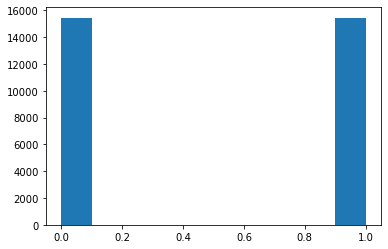

In [43]:
plt.hist(y1)

In [44]:
logmodel=LogisticRegression()
logmodel.fit(X1,y1)
predictions=logmodel.predict(Xnew)
print(classification_report(ynew,predictions))
print(confusion_matrix(ynew,predictions))

              precision    recall  f1-score   support

           0       0.25      0.29      0.27        24
           1       0.84      0.81      0.83       113

    accuracy                           0.72       137
   macro avg       0.55      0.55      0.55       137
weighted avg       0.74      0.72      0.73       137

[[ 7 17]
 [21 92]]


Using OverSampling, the model is able to distinguish class labels upto some extent. Though this model suffers a bit on precision for class label 1 as compared to the model without oversampling. But this improves the precision, recall and f1-score for minority class by a little amount. Inspecting the confusion matrix also, we can see that there is a slight improvement in the model for distinguising between both class label instances

### Random Forest Classifier

In [45]:
model2=RandomForestClassifier()
model2.fit(X,y)
predictions=model2.predict(Xnew)
print(classification_report(ynew,predictions))
print(confusion_matrix(ynew,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.82      1.00      0.90       113

    accuracy                           0.82       137
   macro avg       0.41      0.50      0.45       137
weighted avg       0.68      0.82      0.75       137

[[  0  24]
 [  0 113]]


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
oversample=RandomOverSampler(sampling_strategy='minority')
X2, y2 = oversample.fit_resample(X, y)

(array([15445.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 15445.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

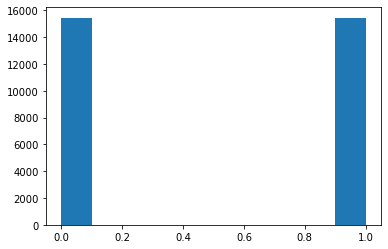

In [47]:
plt.hist(y2)

In [48]:
rfc=RandomForestClassifier()
rfc.fit(X2,y2)
predictions=rfc.predict(Xnew)
print(classification_report(ynew,predictions))
print(confusion_matrix(ynew,predictions))

              precision    recall  f1-score   support

           0       0.13      0.25      0.17        24
           1       0.80      0.65      0.72       113

    accuracy                           0.58       137
   macro avg       0.47      0.45      0.45       137
weighted avg       0.69      0.58      0.63       137

[[ 6 18]
 [39 74]]


### Naive Bayes Classifier

In [49]:
model3=MultinomialNB()
model3.fit(X,y)
predictions=model3.predict(Xnew)
print(classification_report(ynew,predictions))
print(confusion_matrix(ynew,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.82      1.00      0.90       113

    accuracy                           0.82       137
   macro avg       0.41      0.50      0.45       137
weighted avg       0.68      0.82      0.75       137

[[  0  24]
 [  0 113]]


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([15445.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 15445.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

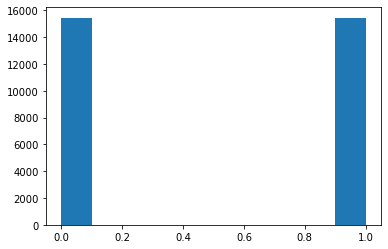

In [50]:
oversample=RandomOverSampler(sampling_strategy='minority')
X3, y3 = oversample.fit_resample(X, y)
plt.hist(y3)

In [51]:
gnb=MultinomialNB()
gnb.fit(X3,y3)
predictions=gnb.predict(Xnew)
print(classification_report(ynew,predictions))
print(confusion_matrix(ynew,predictions))

              precision    recall  f1-score   support

           0       0.13      0.38      0.19        24
           1       0.78      0.47      0.59       113

    accuracy                           0.45       137
   macro avg       0.45      0.42      0.39       137
weighted avg       0.67      0.45      0.52       137

[[ 9 15]
 [60 53]]


### Support Vector Classifier

In [52]:
model4=SVC()
model4.fit(X,y)
predictions=model4.predict(Xnew)
print(classification_report(ynew,predictions))
print(confusion_matrix(ynew,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.82      1.00      0.90       113

    accuracy                           0.82       137
   macro avg       0.41      0.50      0.45       137
weighted avg       0.68      0.82      0.75       137

[[  0  24]
 [  0 113]]


C:\Users\Hp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([15445.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 15445.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

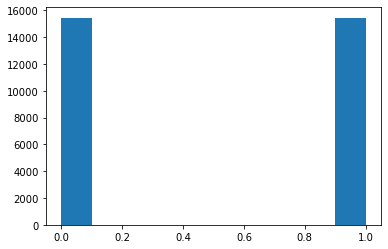

In [53]:
oversample=SMOTE()
X4, y4 = oversample.fit_resample(X, y)
plt.hist(y4)

In [54]:
svc=SVC()
svc.fit(X4,y4)
predictions=svc.predict(Xnew)
print(classification_report(ynew,predictions))
print(confusion_matrix(ynew,predictions))

              precision    recall  f1-score   support

           0       0.26      0.46      0.33        24
           1       0.86      0.73      0.79       113

    accuracy                           0.68       137
   macro avg       0.56      0.59      0.56       137
weighted avg       0.76      0.68      0.71       137

[[11 13]
 [31 82]]


As we can see that in all of the above 4 machine learning algorithms implemented, we are getting an improved result for minority class(0) with a slight decrease in the model's performance for majority class (1). This  has been possible due to the presence of more data points due to oversampling.
Now if in real life, we have actual real data points for minority class and there is no imbalance, then we can expect to get a reasonable model based on only three predictors used, as it is claimed by the researchers

But still, we cannot expect the f1-score to be good for class  (0), i.e. the patients who are actually deceased. Because in this case also, we get the max score as 0.33 for minority class when SVC is applied to the data.
One obvious reason is the class imbalance of data, as synthetically produced data points cannot provide the actual true picture
Other reason is the use of only three predictor variables for research. Though the researchers claim that these predictors are enough to predict survival (class 1), which is True, but it has poor performance on predicting class 0 (which can actually be terrible in real life scenario). There should be more research done on ways to improve the model, so as to have a better performance for class 0 as well

Researchers have used only Random Over Sampling in their research, but I tried other techniques also, with an aim of finding a better one. Though there was not much difference in AUC scores, which suggests that there can be better OverSampling techniques used other than the ones used by me for getting an improved model

# Conclusion

I strongly believe that there could have been more predictor variables, other than the 3 mentioned, that could have lead to a better model performance for both class instances. 
In such cases, imbalanced classes pose a very difficult task for machine learning algorithms, which are designed to do their best on the training dataset provided to them. The presence of less predictor variables further adds to the difficulty of this task, as is seen in this case.

For this project, one can conclude that there is definitely improvement in the performance of a model on imbalanced datasets, after the application of OverSampling techniques on training dataset used for building the model